In [1]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List, k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = (b * cartesian_product(*[t]*dim)).sum(axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@return list of terms of generated function
"""
def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[-0.42592834  0.11624917]
[10.42592834  4.88375083]
[[ 0.          0.        ]
 [ 3.20108884  1.22801063]
 [ 4.68214429  2.25654176]
 [ 5.88148819  3.8362233 ]
 [ 6.80208836  4.18755391]
 [ 7.20276395  4.33819265]
 [ 7.6705346   4.57162234]
 [ 7.85883533  4.68005584]
 [ 8.11113028  4.74688539]
 [ 8.53563329  4.80293349]
 [ 8.84158726  4.73822025]
 [ 8.87664291  4.77742214]
 [ 9.05188837  5.02487411]
 [ 8.87379826  4.87566613]
 [ 9.32460642  4.86913241]
 [ 9.23985011  4.78225452]
 [ 9.46097598  4.77053358]
 [ 9.9443949   4.82531948]
 [10.20276514  4.80356201]
 [10.42592834  4.88375083]]


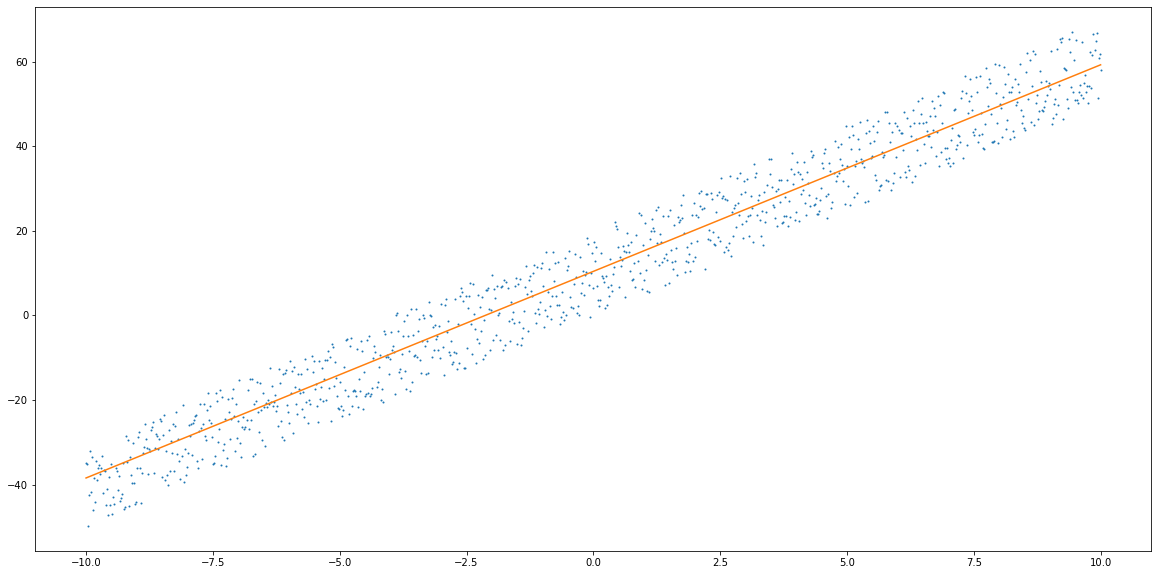

In [3]:
tt = np.linspace(-10, 10, 1000)
b = [10, 5]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [200, 10]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

# Plots dataset
plt.plot(t, ft, 'o', markersize=1)
# Plots approximated function
plt.plot(tt, min_point[1] * tt + min_point[0])

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[0.30146658 0.15299302 0.08452601]
[9.69853342 1.84700698 3.91547399]
[[0.         0.         0.        ]
 [0.73286255 0.1012876  0.35940112]
 [1.22401631 0.21394579 0.85971151]
 [2.38147176 0.3451618  1.22404292]
 [2.87013421 0.4118842  1.6838853 ]
 [3.50264368 0.43611115 1.92431275]
 [4.35764431 0.46582463 2.17657213]
 [4.661793   0.52347071 2.36026695]
 [5.10444412 0.56045036 2.63913083]
 [5.61406991 0.66127193 2.79165153]
 [6.07697891 0.79594463 2.97490369]
 [6.3132781  0.83961569 3.11935415]
 [6.44412832 0.89269755 3.19740361]
 [6.74179648 0.98819935 3.35643583]
 [6.9209438  1.05881176 3.41623205]
 [7.13358073 1.11259508 3.48664105]
 [7.424629   1.1657016  3.58669133]
 [7.6236557  1.21678267 3.61322329]
 [7.83548141 1.26285829 3.75760377]
 [7.90315497 1.31461346 3.80874825]
 [8.18881278 1.38190898 3.85156907]
 [8.26090883 1.40657579 3.88580209]
 [8.37037407 1.42619833 3.88487706]
 [8.41264167 1.44685849 3.89226323]
 [8.38100518 1.479724   3.90883434]
 [8.31098196 1.5036502  3.8829

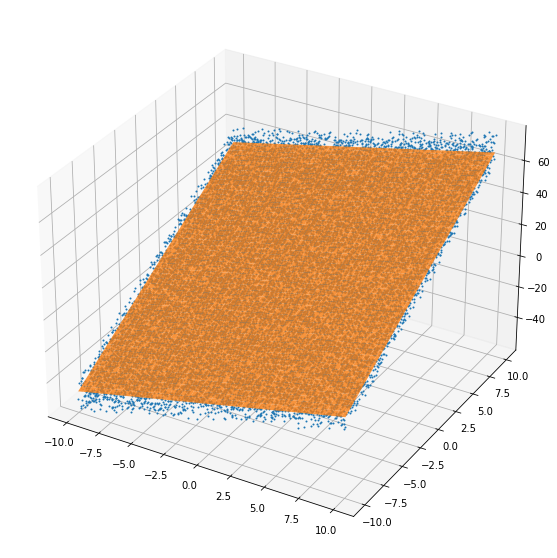

In [4]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [5]:
tt = np.linspace(-10, 10, 20)
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

[ 1.1660197   0.50493912  0.70693297  0.1292325  -0.74133648]
[ 8.8339803   1.49506088  3.29306703  4.8707675  -2.25866352]
[[ 0.          0.          0.          0.          0.        ]
 [ 0.37469544  0.01808453  0.11828615  0.27487285 -0.02748462]
 [ 1.97050079  0.16538966  0.09850848  0.37485083 -0.24469935]
 [ 3.52036701  0.02550342  0.37239084  0.64602661 -0.41688006]
 [ 4.35060197 -0.02797906  0.40742631  0.67348372 -0.45143721]
 [ 4.94263823  0.09371364  0.55314687  0.91842155 -0.49918149]
 [ 4.77417188  0.15566682  0.65374046  0.97295646 -0.67080338]
 [ 4.83047875  0.09543755  0.79045762  0.9824267  -0.6681201 ]
 [ 4.62136849  0.13600546  0.94334143  1.08262702 -0.60757138]
 [ 3.23212243  0.16717896  1.03263109  1.30207757 -0.57623851]
 [ 2.46949379  0.31729524  1.27955402  1.39214896 -0.54255622]
 [ 1.44106807  0.38544031  1.46097999  1.57816544 -0.63305512]
 [ 3.00192532  0.57879596  1.63005629  1.5657481  -0.72846072]
 [ 3.44969473  0.67159881  1.796526    1.86836473 -0.6078

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[-1.46200756e+00 -4.62156198e-02 -4.68072703e-02]
 [ 1.75039113e+00  1.08362257e-01 -5.14782578e-02]
 [ 1.75920001e-01  1.72817810e-01 -2.13616446e-02]
 [ 1.60750747e+00  9.73409674e-02  8.13418871e-04]
 [ 7.13172760e-01  1.82867195e-01 -7.36477002e-02]
 [ 1.44625866e+00  1.13398895e-01 -2.50564730e-02]
 [ 1.01088405e+00  1.78170109e-01  1.80250568e-02]
 [ 1.21186025e+00  1.19501939e-01  1.15978742e-02]
 [ 1.10717338e+00  1.64071518e-01  3.10699621e-02]
 [ 1.18441022e+00  1.19980785e-01  3.97662081e-02]
 [ 1.10677928e+00  1.59223798e-01  1.60071783e-02]
 [ 1.17908871e+00  1.17739112e-01  3.47527184e-02]
 [ 1.26689075e+00  1.79209466e-01  9.27537475e-03]
 [ 1.15903408e+00  1.16827285e-01  3.55469718e-02]
 [ 1.34113333e+00  1.65324555e-01 -1.69167212e-03]
 [ 1.17294753e+00  1.22246712e-01  3.98740790e-02]
 [ 1.32084778e+00  1.56612503e-01  1.74752810e-02]
 [ 1.23735929e+00  1.19312547e-01  1.71774738e-02]
 [ 1.38978688e+00  1.49539211e-01  2.76954865e-02]
 [ 1.25666289e+00  1.18513758e-

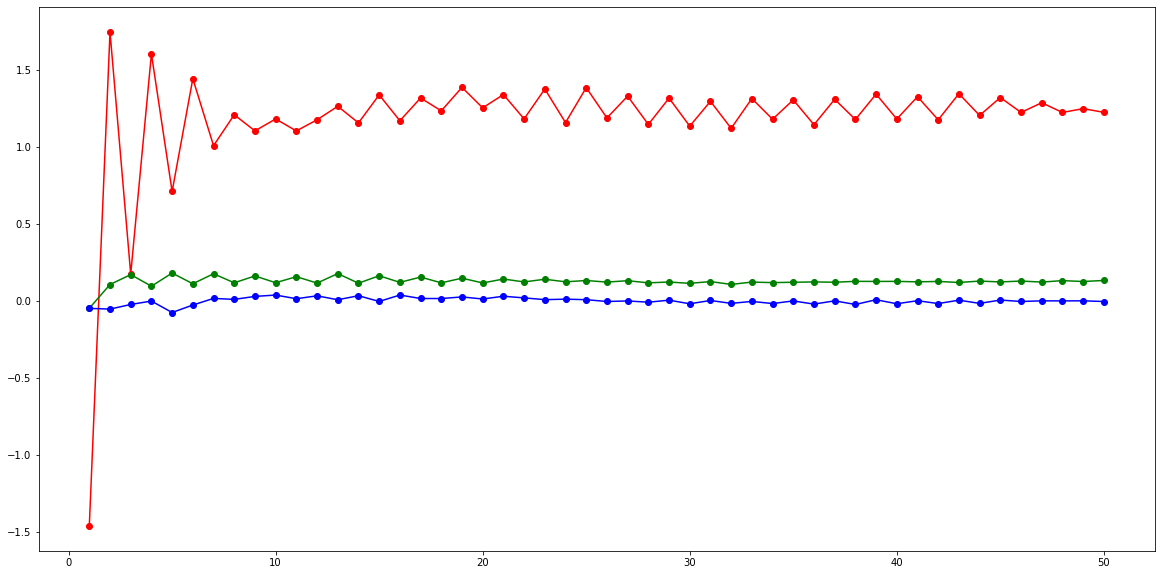

In [6]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [10, 0.2, 0.4]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(b - min_points)
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')

## SGM with momentum

[-0.68968194  0.27546985]
[9.31031806 5.27546985]
[[0.         0.        ]
 [0.76138606 5.50844892]
 [1.81994126 7.75249159]
 [2.94581262 5.96389313]
 [3.8430535  4.36299748]
 [4.63394319 3.91234567]
 [5.63676079 5.67574789]
 [6.49049713 5.69716332]
 [7.15099223 4.82068891]
 [7.68066697 4.93831749]
 [8.09715452 5.29674043]
 [8.35171168 4.93698324]
 [8.63806363 4.88292548]
 [8.85342215 5.13078421]
 [9.00673263 4.94293335]
 [9.16504673 5.10219762]
 [9.21106318 4.97372087]
 [9.28511563 4.90439926]
 [9.27033834 4.73254361]
 [9.31031806 5.27546985]]


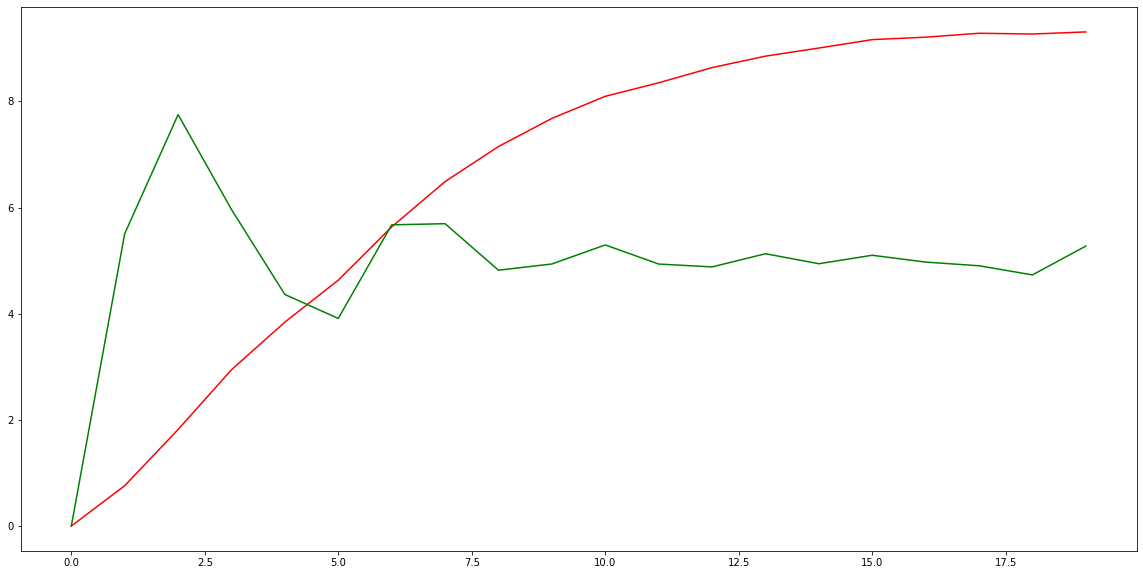

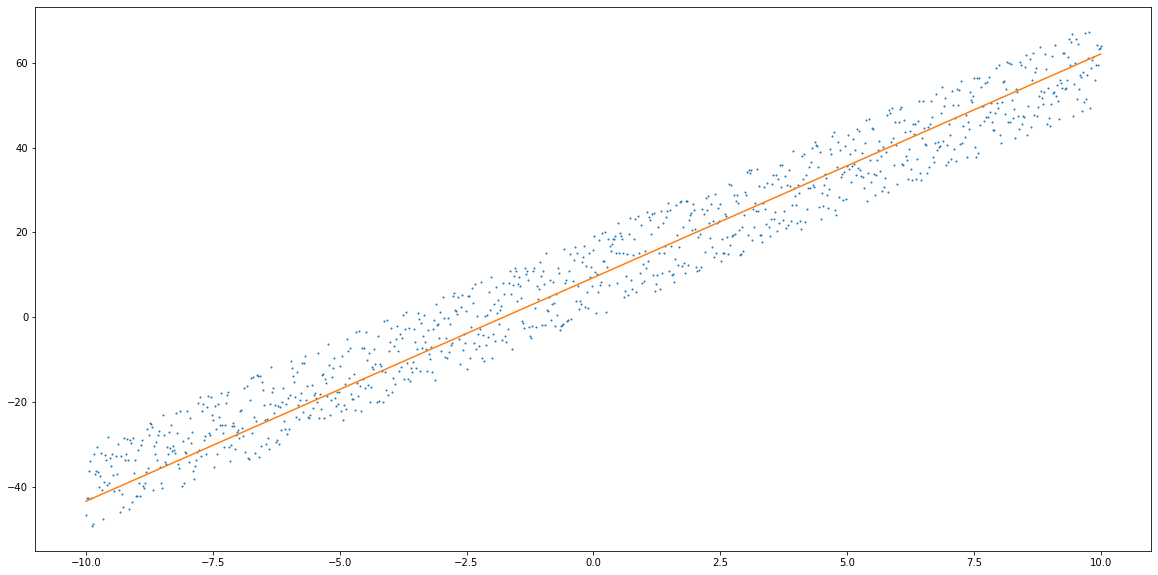

In [7]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.array(grad_appr(sum_fun, x, [0, batch_size]))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [i * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Nesterov SGD

[-0.86584479  0.21717385]
[9.13415521 5.21717385]
[[0.         0.        ]
 [0.75176239 5.11399469]
 [1.66463145 8.09481453]
 [2.69169074 6.59536409]
 [3.6658099  4.27710458]
 [4.53991905 3.66274302]
 [5.4807862  4.94370043]
 [6.25977286 5.56001388]
 [6.89851416 5.16972333]
 [7.39542391 4.96708997]
 [7.78290897 5.08237081]
 [8.13971493 5.06366874]
 [8.31497859 5.05600367]
 [8.48246148 4.93033655]
 [8.62223425 4.95243901]
 [8.66284951 5.22163845]
 [8.73544291 5.16928576]
 [8.88220993 5.20698915]
 [9.02415806 5.22955961]
 [9.13415521 5.21717385]]


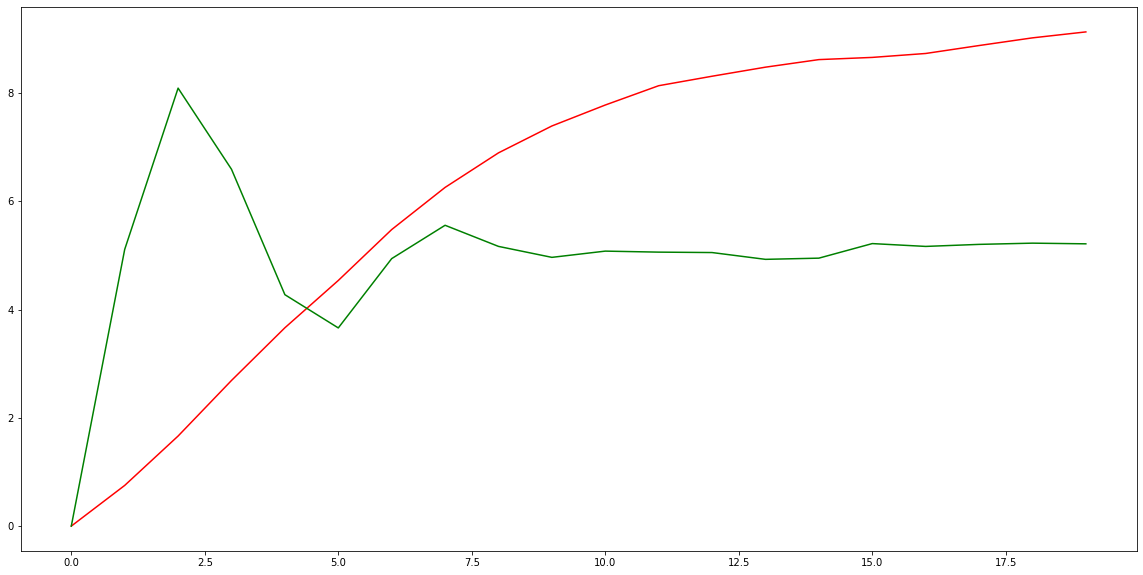

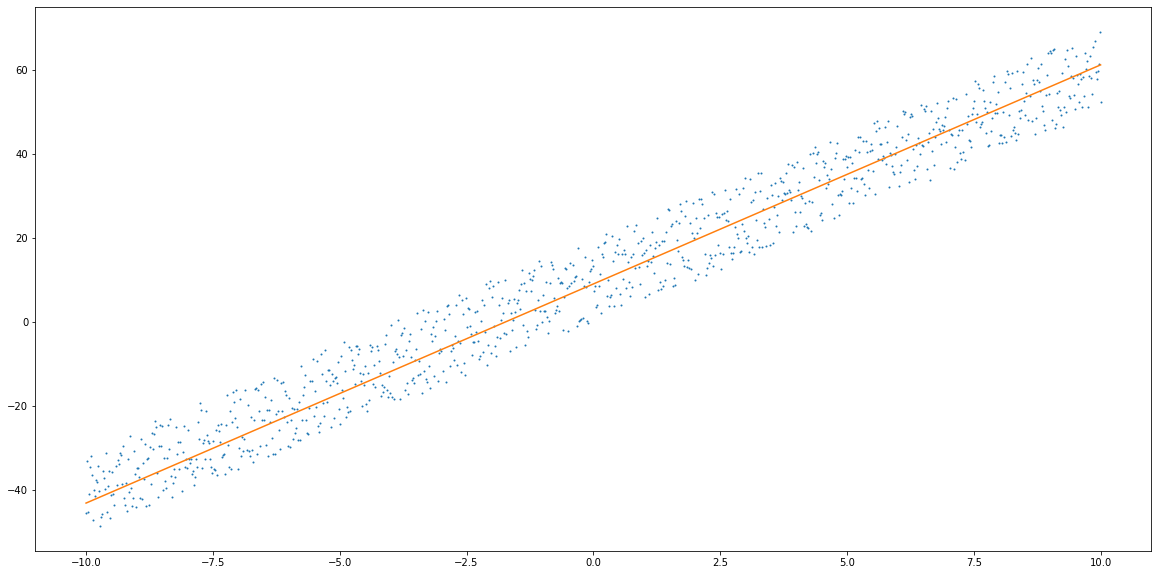

In [8]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = 0
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with AdaGrad

[1.27326857 0.05726502]
[18.72673143  4.94273498]
[[ 0.          0.        ]
 [20.         20.        ]
 [32.38609369  0.60792531]
 [21.53930298  5.6823553 ]
 [19.98213975  4.6116513 ]
 [19.97967807  4.84353624]
 [19.64804754  4.90133244]
 [19.45731558  5.14694823]
 [20.1340441   4.93931107]
 [19.84850109  4.86373202]
 [20.1870341   5.11321644]
 [19.1762834   5.0024293 ]
 [19.79659155  5.17790085]
 [21.19520847  5.06618429]
 [20.45380372  4.90530945]
 [19.74202216  4.90117677]
 [20.45351668  5.01544804]
 [20.69529914  4.8748473 ]
 [20.33059005  4.99377946]
 [18.72673143  4.94273498]]


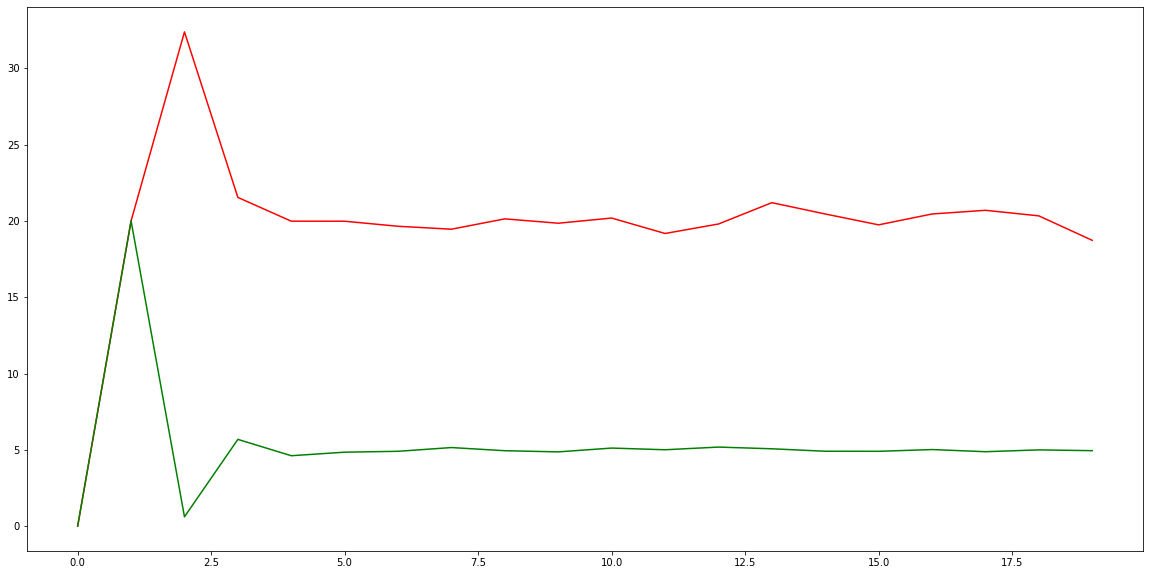

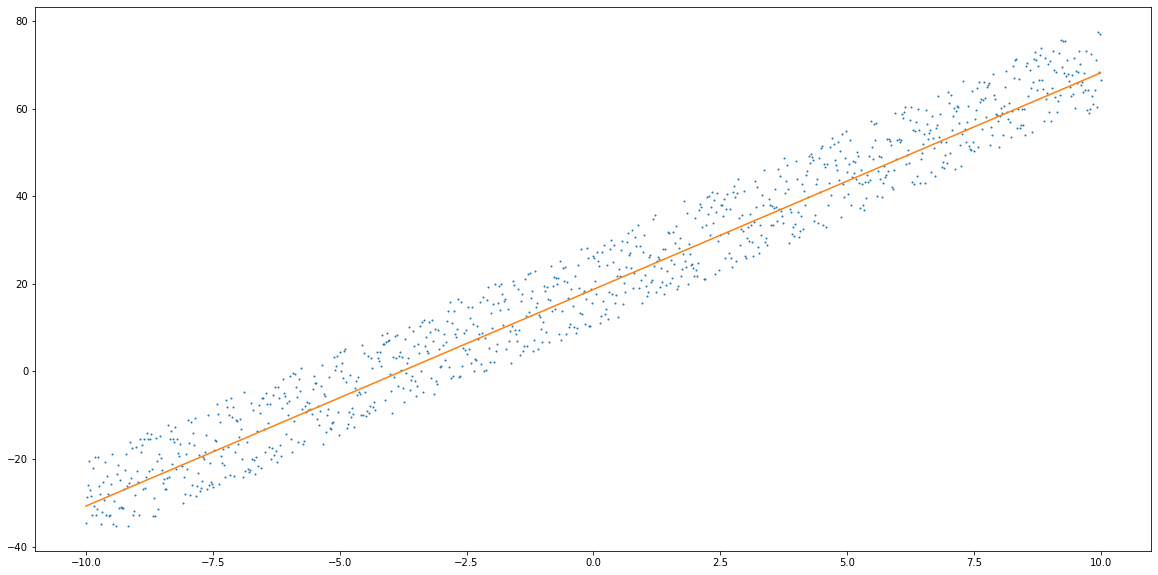

In [9]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [20, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [1000]

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with RMSProp

[ 0.29010466 -0.76090297]
[14.70989534  5.76090297]
[[ 0.          0.        ]
 [ 4.42718872  4.42718872]
 [ 6.58222226  4.47984279]
 [ 7.93756251  4.87258013]
 [ 9.25926202  4.87881808]
 [10.51692537  4.95258077]
 [11.70577004  4.94151678]
 [11.92841647  4.83130288]
 [12.21497238  4.90230274]
 [12.94098863  5.34975787]
 [13.34421417  5.13406381]
 [13.70210891  4.81324381]
 [14.11550192  5.16326449]
 [14.4414747   5.01893785]
 [14.71161979  4.74241637]
 [14.40759997  5.27484986]
 [14.47794015  4.69245013]
 [14.40822525  5.67826876]
 [14.58193266  4.74802343]
 [14.70989534  5.76090297]]


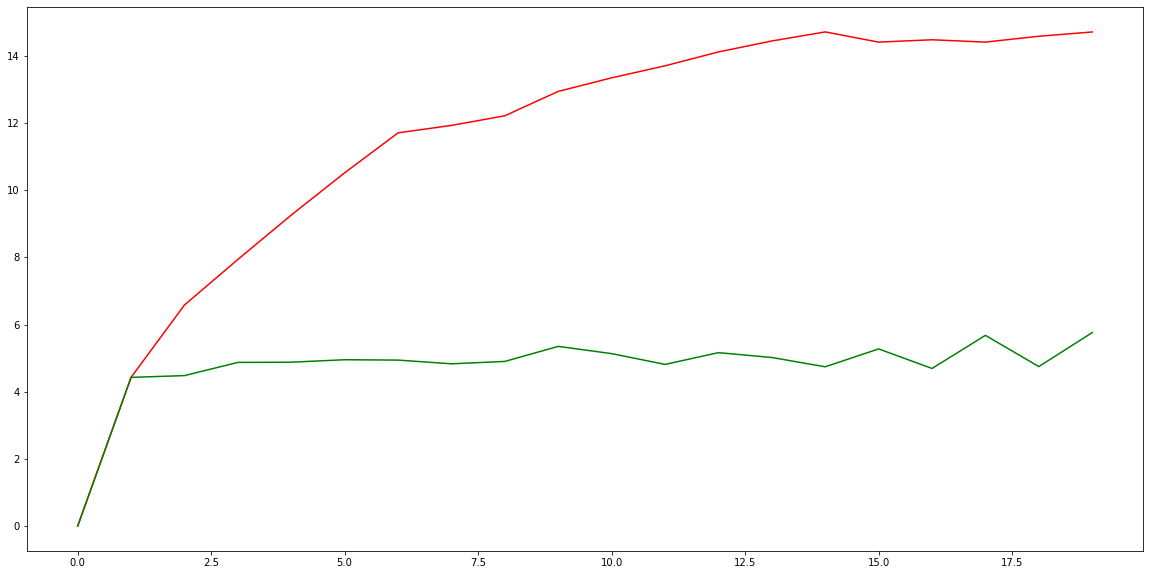

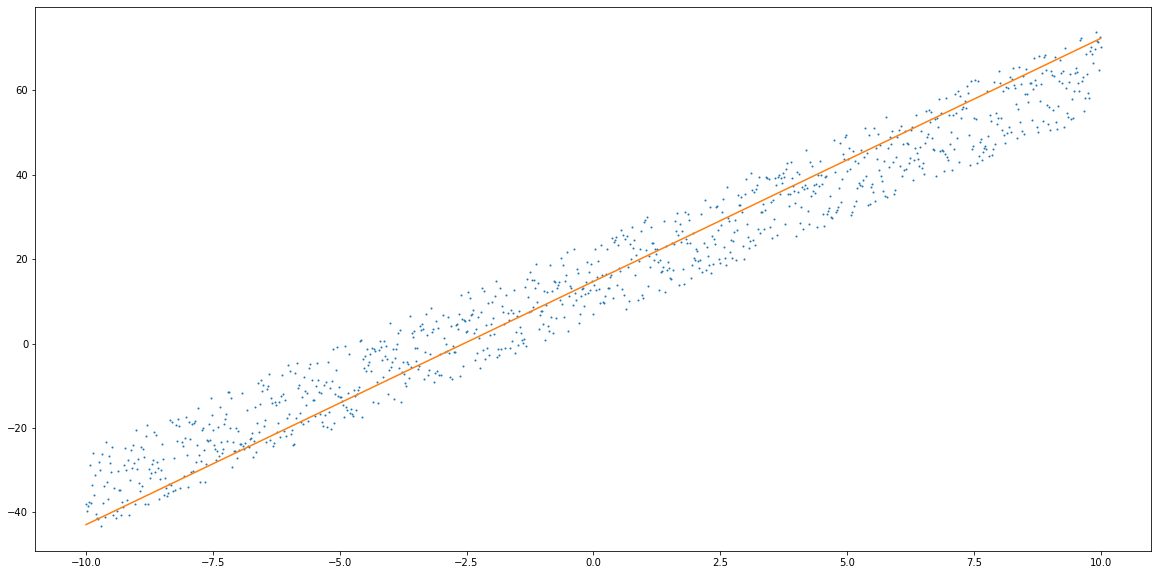

In [10]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [70]
b = [0.9]

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with Adam

[0.14143303 0.31035096]
[14.85856697  4.68964904]
[[ 0.          0.        ]
 [ 0.95122941  0.95122942]
 [ 1.93726719  1.96281762]
 [ 2.87733491  2.86429459]
 [ 3.74538285  3.64042244]
 [ 4.55777805  4.28257062]
 [ 5.37180094  4.86419458]
 [ 6.16944545  5.28443459]
 [ 6.99275386  5.42279072]
 [ 7.80481455  5.51907358]
 [ 8.62367757  5.43838649]
 [ 9.47093214  5.21356102]
 [10.25466306  4.93161069]
 [11.04869217  5.05391757]
 [11.85659542  5.02314025]
 [12.64695368  4.83093196]
 [13.31319287  4.89298989]
 [14.01095793  5.343134  ]
 [14.43828599  4.97356675]
 [14.85856697  4.68964904]]


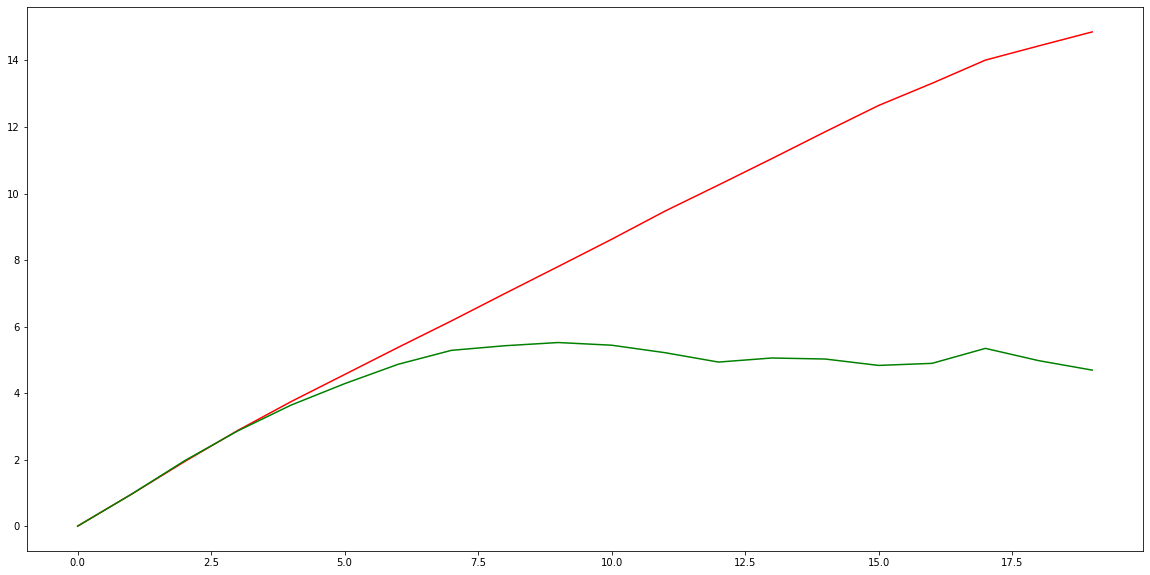

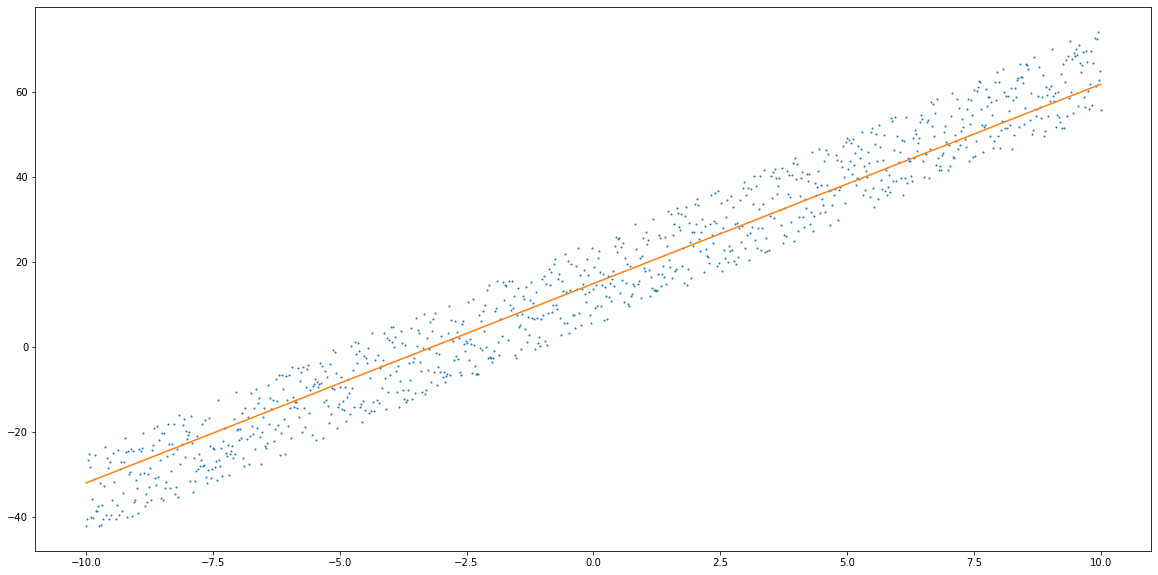

In [11]:
"""
Finds minimum of the function using stochastic gradient descent with adam.
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    m = 0
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [50]
b1 = [0.5]
b2 = [0.6]
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Попытка построить линии контура для графика минимизируемой функции
Работает, но чудовищно медленно. Следует найти способ сделать это средствами numpy

[[ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]
 [ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]
 [ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]
 ...
 [ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]
 [ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]
 [ 0.          0.3331164   0.6662328  ... 12.32530672 12.65842311
  12.99153951]]
[[ 476.58170245  473.31739092  470.16404592 ...  429.70588776
   430.547338    431.49975478]
 [ 421.7183888   418.45407727  415.30073227 ...  374.8425741
   375.68402435  376.63644112]
 [ 370.62868456  367.36437303  364.21102804 ...  323.75286987
   324.59432011  325.54673689]
 ...
 [ 959.86297091  956.59865938  953.44531439 ...  912.98715622
   913.82860646  914.78102324]
 [1044.62320579 1041.35889426 1038.20554927 ...  997.7473911
   998.58884135  999.54125812]
 [1133.1570501  1129.89273857 1126.73939

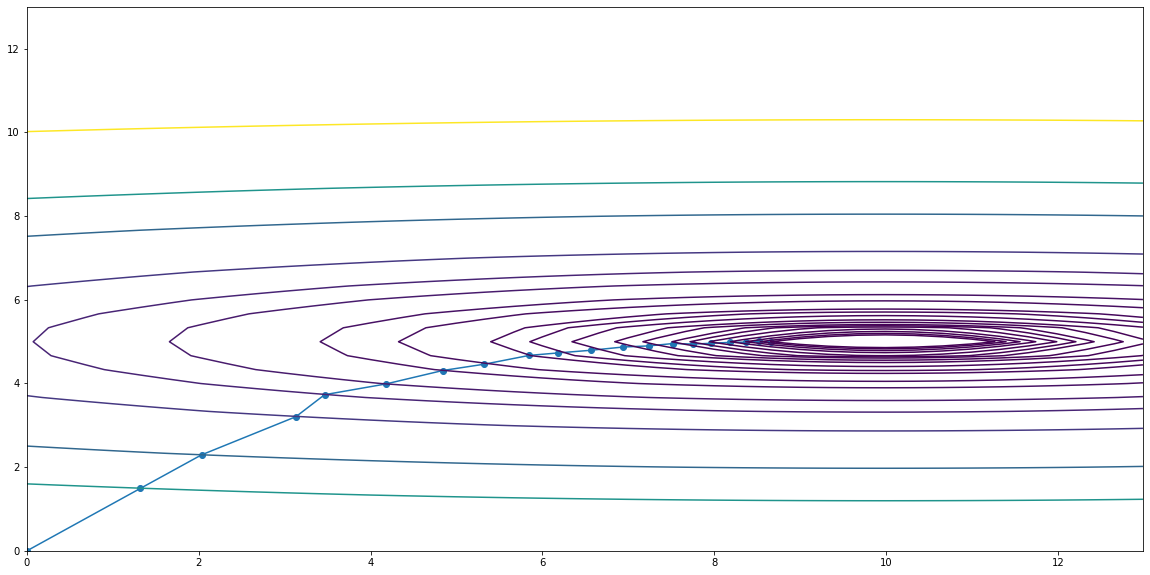

In [13]:
def generate_minimized_fun1(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t)), axis=1) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

# def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
#     sum_fun = np.empty(len(t), dtype=partial)
#     for i in range(len(t)):
#         # Captures t[i] and ft[i] from current context
#         sum_fun[i] = partial(lambda t, ft, a: 1 / (2 * len(t)) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i])
#     np.random.shuffle(sum_fun)
#     return sum_fun

tt = np.linspace(-10, 10, 100)
b = [10, 5]
t, ft = generate_dataset(b, 1, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [10, 0.8]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

# def f(a):
#     print(np.concatenate(([1], [2])))
#     p = a * np.concatenate(([1], [2]))
#     print('p:', p)
#     print('sum:', np.sum(p, axis=1))
#     print(np.square([[5, 2], [3, 4]]))
#     return 1 / (2 * 10) * np.square(np.sum(a * np.concatenate(([1], [2])), axis=1) - 5)
# print(f([[5, 2], [3, 4]]))

# def g(a):
#     t =
#     return 1 / (2 * len(t)) * np.square(np.sum(a * np.concatenate(([1], t))) - ft)

# # Plots dataset
# plt.plot(t, ft, 'o', markersize=1)
# # Plots approximated function
# plt.plot(tt, min_point[1] * tt + min_point[0])

# ss = generate_minimized_fun1(t, ft)

f = reduce(lambda f1, f2: lambda x: f1(x) + f2(x), sum_fun)
# print(points)
# print(f(points))
# print(f([12, 5]))
# print(min_point)
# print(points)

ax = plt.figure().add_subplot()
ax.plot(points[:, 0], points[:, 1], 'o-')
# tt = np.linspace(min(*points[:, 0], *points[:, 1]) * 3 / 2, max(*points[:, 0], *points[:, 1]) * 3 / 2, 40)
# X = np.meshgrid(tt, tt)
# print(tt)
# print(min_point)
# print(f(points[0]))
# print(X)
# print(f(X))
# ax.contour(X[0], X[1], f(X), levels=sorted([f(p) for p in points]))
# Works
tt = np.linspace(min(*points[:, 0], *points[:, 1]) * 3 / 2, max(*points[:, 0], *points[:, 1]) * 3 / 2, 40)
X, Y = np.meshgrid(tt, tt)
print(X)

# Y, X  =  np.mgrid[0:10:1, 0:10:1]
Z = np.zeros_like(Y)

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        Z[i,j] = f([X[i,j], Y[i,j]])

print(Z)

ax.contour(X, Y, Z, levels=sorted([f(p) for p in points]))